In [1]:
#import Library

In [259]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [260]:
df = pd.read_csv("/Users/anupbanerjee/Downloads/Project 3/OnlineNewsPopularity/OnlineNewsPopularity.csv")
df3 = df.drop(["url","101249.62","3395.380184","1400"], axis = 1)
df3.head(1)


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,731,12,219,0.663594,1.0,0.815385,4,2,1,0,...,0.1,0.7,-0.35,-0.6,-0.2,0.5,-0.1875,0.0,0.1875,593


### Removing Insignificant columns


In [224]:
df3 = df3.drop(['timedelta','n_non_stop_unique_tokens','n_non_stop_words',
                'average_token_length','kw_max_min','kw_max_avg',
                'self_reference_avg_sharess','is_weekend',
                'rate_positive_words','rate_negative_words',
                'avg_positive_polarity','avg_negative_polarity',
                'abs_title_sentiment_polarity','kw_avg_max'],axis = 1)

In [222]:
df3.corr().to_csv(r"/Users/anupbanerjee/Downloads/Project 3/OnlineNewsPopularity/Correlation.csv")

In [261]:
df3.loc[(df3['shares'] <  df3["shares"].median()), 'share_class'] = "unpopular"
df3.loc[(df3['shares'] >= df3["shares"].median()), 'share_class'] = "popular"

In [262]:
c1 = df3[df3['share_class'] == "unpopular"]
c2 = df3[df3['share_class'] == "popular"]

### Outlier Treatment - IQR capping

In [263]:
for i in (c1.drop(['data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world','weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday',"share_class","shares"], axis = 1).columns):
    Q1 = c1[i].quantile(0.25)
    Q3 = c1[i].quantile(0.75)
    IQR = Q3 - Q1
    
    c1[i][c1[i]>(Q3+1.5*IQR)] = Q3
    c1[i][c1[i]<(Q1-1.5*IQR)] = Q1
    
    
for i in (c2.drop(['data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world','weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday',"share_class","shares"], axis = 1).columns):
    Q1 = c2[i].quantile(0.25)
    Q3 = c2[i].quantile(0.75)
    IQR = Q3 - Q1
    
    c2[i][c2[i]>(Q3+1.5*IQR)] = Q3
    c2[i][c2[i]<(Q1-1.5*IQR)] = Q1

In [264]:
datasets = [c1,c2]
dfd = pd.concat(datasets)

### Feature Engineering

In [265]:
c = ['n_tokens_content','n_tokens_title','num_imgs',"num_hrefs","num_self_hrefs"]
c1 = []
c2= []
for i in c: 
    dfd.loc[(dfd[i] <= np.percentile(dfd[i],33)), str(i)+"_class"] = "low"
    dfd.loc[(dfd[i] >np.percentile(dfd[i],33)) & (dfd[i]<= np.percentile(dfd[i],67)), str(i)+"_class"] = "Medium"
    dfd.loc[(dfd[i] >np.percentile(dfd[i],67)), str(i)+"_class"] = "high"
    c1.append(str(i)+"_class")
    c2.append(i)
dfd[c1].head(1)

,n_tokens_content_class,n_tokens_title_class,num_imgs_class,num_hrefs_class,num_self_hrefs_class
0,low,high,low,low,low


In [266]:
dfd["share_class"].value_counts(normalize = True)

popular      0.533599
unpopular    0.466401
Name: share_class, dtype: float64

In [88]:
dfd.to_csv(r"/Users/anupbanerjee/Downloads/Project 3/OnlineNewsPopularity/OnlineNewsPopularity_V3.csv")

### Classification of Share class

In [267]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
l = ["share_class"]
for i in l:
    dfd[i] = le.fit_transform(dfd[i])

### Modelling

In [268]:
X = dfd.drop(["n_tokens_title","n_tokens_content","shares","share_class",'num_hrefs',
              'num_self_hrefs', 'num_imgs',"shares",'share_class'], axis = 1)
y = dfd["share_class"]

In [269]:
X = pd.get_dummies(X,columns = ["n_tokens_content_class","n_tokens_title_class",'num_hrefs_class',
                                'num_self_hrefs_class','num_imgs_class'])

### RFE - 55 features

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
logreg = LogisticRegression(max_iter = 4000)
rfe = RFE(logreg, 55)             # running RFE with 13 variables as output
rfe = rfe.fit(X,y)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=55 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[ True False  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True False  True  True  True
  True  True  True  True False False  True  True  True False  True False
  True False  True  True  True False False  True  True False False  True
  True  True  True  True False  True  True  True  True]
[ 1  8  1  1  1  1  1 11  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  3  1  1  1  1  1  1 15  1  1  1  1  1  1  1  9 14  1  1  1  6  1 12
  1 13  1  1  1  2  4  1  1  5 10  1  1  1  1  1  7  1  1  1  1]


In [102]:
cols = list(X.columns)
model = LogisticRegression(max_iter = 4000)
#Initializing RFE model
rfe = RFE(model, n_features_to_select = 55)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['timedelta', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'LDA_00', 'LDA_01',
       'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'max_positive_polarity',
       'min_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
  

In [105]:
X55 = X[['timedelta', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'LDA_00', 'LDA_01',
       'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'max_positive_polarity',
       'min_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'n_tokens_content_class_high', 'n_tokens_content_class_low',
       'n_tokens_title_class_low', 'num_hrefs_class_Medium',
       'num_hrefs_class_high', 'num_hrefs_class_low',
       'num_self_hrefs_class_Medium', 'num_self_hrefs_class_low',
       'num_imgs_class_Medium', 'num_imgs_class_high', 'num_imgs_class_low']]

### Standard Scaler -RFE 55

In [106]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_std = sc.fit_transform(X55)
X1 = pd.DataFrame(X_std,columns = X55.columns)

In [109]:
lb_class = LabelEncoder()
le = ['weekday_is_tuesday', 'weekday_is_wednesday',
       'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
       'weekday_is_sunday', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world']
for i in le:
    X1[i] = lb_class.fit_transform(X1[i])

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size = 0.3, random_state = 42, stratify = y)

In [112]:
import sklearn.linear_model as lm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
lr = lm.LogisticRegression(max_iter= 4000)
lr.fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_train_prob = lr.predict_proba(X_train)[:,1]
y_test_pred = lr.predict(X_test)
y_test_prob = lr.predict_proba(X_test)[:,1]

lr.score(X1,y),lr.score(X_test,y_test)

(0.8596761174452628, 0.8584160080712965)

In [113]:
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
print("Accuracy",accuracy_score(y_train,y_train_pred))
print("AUC train", roc_auc_score(y_train,y_train_prob))
print("F1 train", f1_score(y_train,y_train_pred))
print("recall",recall_score(y_train,y_train_pred))
print("Precision",precision_score(y_train,y_train_pred))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred))
print("AUC test",roc_auc_score(y_test,y_test_prob))
print("F1 test",f1_score(y_test,y_test_pred))
print("recall",recall_score(y_test,y_test_pred))
print("Precision",precision_score(y_test,y_test_pred))

Accuracy 0.8602162162162162
AUC train 0.9382145249431791
F1 train 0.8531182551402932
recall 0.8703546318473306
Precision 0.836551314421506


Accuracy 0.8584160080712965
AUC test 0.9363531639575743
F1 test 0.8511578575216547
recall 0.8680367766360195
Precision 0.834922836830241


### RFE - 50 features

In [117]:
cols = list(X.columns)
model = LogisticRegression(max_iter = 4000)
#Initializing RFE model
rfe = RFE(model, n_features_to_select = 50)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['timedelta', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'average_token_length', 'num_keywords', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max',
       'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'self_reference_avg_sharess',
       'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'LDA_00', 'LDA_01',
       'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'max_positive_polarity',
       'min_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'n_tokens_content_class_high', 'n_tokens_content_class_low',
       'n_tokens_title_c

In [124]:
X50 = X[selected_features_rfe.index]

### Standard Scaler -RFE 50

In [153]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_std = sc.fit_transform(X50)
X1 = pd.DataFrame(X_std,columns = X50.columns)

In [154]:
lb_class = LabelEncoder()
le = ['weekday_is_tuesday', 'weekday_is_wednesday',
      'weekday_is_friday', 'weekday_is_saturday',
       'weekday_is_sunday', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech']
for i in le:
    X1[i] = lb_class.fit_transform(X1[i])

In [157]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size = 0.3, random_state = 42, stratify = y)

In [156]:
import sklearn.linear_model as lm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
lr = lm.LogisticRegression(max_iter= 4000)
lr.fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_train_prob = lr.predict_proba(X_train)[:,1]
y_test_pred = lr.predict(X_test)
y_test_prob = lr.predict_proba(X_test)[:,1]

lr.score(X1,y),lr.score(X_test,y_test)

(0.8506961961456967, 0.8484950395157222)

In [137]:
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
print("Accuracy",accuracy_score(y_train,y_train_pred))
print("AUC train", roc_auc_score(y_train,y_train_prob))
print("F1 train", f1_score(y_train,y_train_pred))
print("recall",recall_score(y_train,y_train_pred))
print("Precision",precision_score(y_train,y_train_pred))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred))
print("AUC test",roc_auc_score(y_test,y_test_prob))
print("F1 test",f1_score(y_test,y_test_pred))
print("recall",recall_score(y_test,y_test_pred))
print("Precision",precision_score(y_test,y_test_pred))

Accuracy 0.8516396396396396
AUC train 0.9310452450022947
F1 train 0.8444242905188376
recall 0.8632465425326431
Precision 0.826405325443787


Accuracy 0.8484950395157222
AUC test 0.9301432856354576
F1 test 0.8414290742696233
recall 0.8619073372994411
Precision 0.8219013237063778


### RFE - 40 features

In [140]:
cols = list(X.columns)
model = LogisticRegression(max_iter = 4000)
#Initializing RFE model
rfe = RFE(model, n_features_to_select = 40)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['timedelta', 'n_non_stop_words', 'average_token_length', 'num_keywords',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech', 'kw_min_min',
       'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_min_avg',
       'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'self_reference_avg_sharess',
       'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_saturday',
       'weekday_is_sunday', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04',
       'global_subjectivity', 'rate_positive_words', 'max_positive_polarity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'n_tokens_content_class_high', 'n_tokens_title_class_low',
       'num_hrefs_class_high', 'num_self_hrefs_class_Medium',
       'num_self_hrefs_class_low', 'num_imgs_class_Medium',
       'num_imgs_class_high'],
      dtype='object')


In [143]:
X40 = X[['timedelta', 'n_non_stop_words', 'average_token_length', 'num_keywords',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech', 'kw_min_min',
       'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_min_avg',
       'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'self_reference_avg_sharess',
       'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_saturday',
       'weekday_is_sunday', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04',
       'global_subjectivity', 'rate_positive_words', 'max_positive_polarity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'n_tokens_content_class_high', 'n_tokens_title_class_low',
       'num_hrefs_class_high', 'num_self_hrefs_class_Medium',
       'num_self_hrefs_class_low', 'num_imgs_class_Medium',
       'num_imgs_class_high']]

### Standard Scaler -RFE 40

In [144]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_std = sc.fit_transform(X40)
X1 = pd.DataFrame(X_std,columns = X40.columns)

In [146]:
lb_class = LabelEncoder()
le = ['weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_saturday',
       'weekday_is_sunday', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech']
for i in le:
    X1[i] = lb_class.fit_transform(X1[i])

In [147]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size = 0.3, random_state = 42, stratify = y)

In [148]:
import sklearn.linear_model as lm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
lr = lm.LogisticRegression(max_iter= 4000)
lr.fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_train_prob = lr.predict_proba(X_train)[:,1]
y_test_pred = lr.predict(X_test)
y_test_prob = lr.predict_proba(X_test)[:,1]

lr.score(X1,y),lr.score(X_test,y_test)

(0.8500655836948845, 0.8475702034639314)

In [149]:
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
print("Accuracy",accuracy_score(y_train,y_train_pred))
print("AUC train", roc_auc_score(y_train,y_train_prob))
print("F1 train", f1_score(y_train,y_train_pred))
print("recall",recall_score(y_train,y_train_pred))
print("Precision",precision_score(y_train,y_train_pred))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred))
print("AUC test",roc_auc_score(y_test,y_test_prob))
print("F1 test",f1_score(y_test,y_test_pred))
print("recall",recall_score(y_test,y_test_pred))
print("Precision",precision_score(y_test,y_test_pred))

Accuracy 0.8511351351351352
AUC train 0.9303295854861825
F1 train 0.8438480438480439
recall 0.8623966622884958
Precision 0.826080521018354


Accuracy 0.8475702034639314
AUC test 0.9293154628128895
F1 test 0.840193918025562
recall 0.8592031728862448
Precision 0.8220075888237324


### Standard Scaler

In [298]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#for i not in 
X_std = sc.fit_transform(X)
X1 = pd.DataFrame(X_std,columns = X.columns)

In [299]:
lb_class = LabelEncoder()
le = ['weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
       'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
       'weekday_is_sunday','data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world']
for i in le:
    X1[i] = lb_class.fit_transform(X1[i])

In [281]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size = 0.3, random_state = 42, stratify = y)

### Kbest

In [328]:
X2 = X1.copy(deep=True)
selector = SelectKBest(mutual_info_classif, k=50)
selector.fit(X2, y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
features_df_new = X2.iloc[:,cols]
features_df_new.columns

Index(['timedelta', 'n_unique_tokens', 'n_non_stop_unique_tokens',
       'num_videos', 'average_token_length', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_thursday',
       'weekday_is_saturday', 'weekday_is_sunday', 'LDA_00', 'LDA_01',
       'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'a

In [329]:

X5 = features_df_new.drop(['n_tokens_content_class_low', 'num_hrefs_class_Medium',
       'num_self_hrefs_class_low', 'num_imgs_class_Medium',
       'num_imgs_class_high', 'num_imgs_class_low','data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world','weekday_is_thursday',
       'weekday_is_saturday', 'weekday_is_sunday'],axis = 1)

In [330]:
X5.columns


Index(['timedelta', 'n_unique_tokens', 'n_non_stop_unique_tokens',
       'num_videos', 'average_token_length', 'kw_min_min', 'kw_max_min',
       'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg',
       'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'self_reference_avg_sharess', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_sentiment_polarity'],
      dtype='object')

In [337]:
X2 = X1[['timedelta', 'n_unique_tokens', 'n_non_stop_unique_tokens',
       'num_videos', 'average_token_length', 'kw_min_min', 'kw_max_min',
       'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg',
       'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'self_reference_avg_sharess', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_sentiment_polarity','data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world','weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday','n_tokens_content_class_Medium',
       'n_tokens_content_class_high', 'n_tokens_content_class_low',
       'n_tokens_title_class_Medium', 'n_tokens_title_class_high',
       'n_tokens_title_class_low', 'num_hrefs_class_Medium',
       'num_hrefs_class_high', 'num_hrefs_class_low',
       'num_self_hrefs_class_Medium', 'num_self_hrefs_class_high',
       'num_self_hrefs_class_low', 'num_imgs_class_Medium',
       'num_imgs_class_high', 'num_imgs_class_low']]

In [339]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2,y,test_size = 0.3, random_state = 42, stratify = y)

In [336]:
lr = lm.LogisticRegression(max_iter= 4000)
lr.fit(X_train2,y_train2)
y_train_pred2 = lr.predict(X_train2)

y_test_pred2 = lr.predict(X_test2)


print("Accuracy",accuracy_score(y_train2,y_train_pred2))
print("Accuracy",accuracy_score(y_test2,y_test_pred2))

Accuracy 0.860936936936937
Accuracy 0.8564822599630065


In [290]:
X_new = SelectKBest(mutual_info_classif, k=44).fit_transform(X1, y)
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_new,y,test_size = 0.3, random_state = 42, stratify = y)
import sklearn.linear_model as lm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
lr = lm.LogisticRegression(max_iter= 4000)
lr.fit(X_train1,y_train1)
y_train_pred1 = lr.predict(X_train1)

y_test_pred1 = lr.predict(X_test1)


print("Accuracy",accuracy_score(y_train1,y_train_pred1))
print("Accuracy",accuracy_score(y_test1,y_test_pred1))

Accuracy 0.8597837837837838
Accuracy 0.8558096519253405


In [292]:
X_new.shape

(39644, 44)

### Logistic Regression

In [340]:
import sklearn.linear_model as lm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
lr = lm.LogisticRegression(max_iter= 4000)
lr.fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_train_prob = lr.predict_proba(X_train)[:,1]
y_test_pred = lr.predict(X_test)
y_test_prob = lr.predict_proba(X_test)[:,1]

print("Accuracy",accuracy_score(y_train,y_train_pred))
print("Accuracy",accuracy_score(y_test,y_test_pred))

Accuracy 0.8621621621621621
Accuracy 0.8575752480242139


In [341]:
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
print("Accuracy",accuracy_score(y_train,y_train_pred))
print("AUC train", roc_auc_score(y_train,y_train_prob))
print("F1 train", f1_score(y_train,y_train_pred))
print("recall",recall_score(y_train,y_train_pred))
print("Precision",precision_score(y_train,y_train_pred))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred))
print("AUC test",roc_auc_score(y_test,y_test_prob))
print("F1 test",f1_score(y_test,y_test_pred))
print("recall",recall_score(y_test,y_test_pred))
print("Precision",precision_score(y_test,y_test_pred))

Accuracy 0.8621621621621621
AUC train 0.9389033851878539
F1 train 0.8549982940975775
recall 0.871281773931855
Precision 0.8393122953259898


Accuracy 0.8575752480242139
AUC test 0.9370484555984612
F1 test 0.850115023889577
recall 0.8660537227330088
Precision 0.8347523892267593


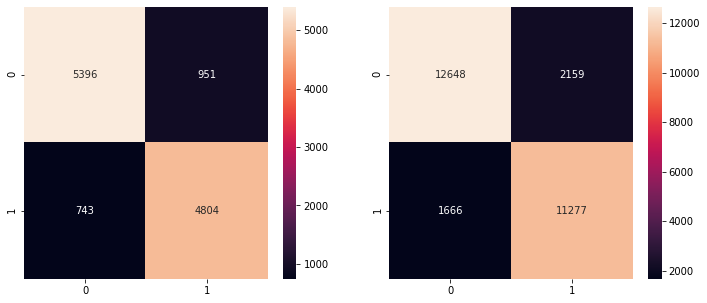

In [357]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_pred),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_pred),fmt = 'd',annot = True,ax = axes[1])
plt.savefig("Logistic CM.png")
plt.show()

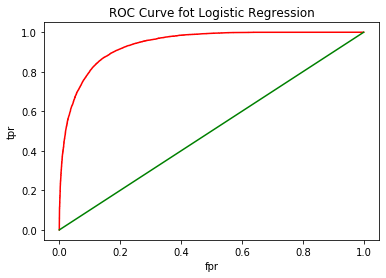

In [358]:
fpr, tpr, thresholds =roc_curve(y_train,y_train_prob)
plt.plot(fpr,tpr,"r")
plt.plot(fpr,fpr,"g")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve fot Logistic Regression")
plt.savefig('ROC Curve fot Logistic Regression.png')
plt.show()

In [436]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
scoring = {'accuracy' : make_scorer(accuracy_score)}

model_lr = lm.LogisticRegression(max_iter= 4000)
results_lr = cross_validate(model_lr, X2, y, cv=10, scoring = scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(results_lr['test_accuracy']), np.std(results_lr['test_accuracy']) * 2))

Accuracy: 0.85 (+/- 0.13)


In [432]:
results_lr

{'fit_time': array([1.12710309, 0.60337019, 0.91306186, 0.48380303, 0.76457596]),
 'score_time': array([0.01495409, 0.00486183, 0.00499129, 0.00573993, 0.00586486]),
 'test_accuracy': array([0.95371421, 0.80476731, 0.82645983, 0.81624417, 0.80045409])}

# RB BOX

In [455]:
rb = []
rb.append(results_lr['test_accuracy'])
rb.append(results_dt['test_accuracy'])
rb.append(results_rf['test_accuracy'])
rb.append(results['test_accuracy'])

In [456]:
rb

[array([0.98587642, 0.96216898, 0.87213115, 0.79016393, 0.8191221 ,
        0.83602422, 0.82542886, 0.80978809, 0.81937437, 0.80398587]),
 array([0.94882883, 0.95387387, 0.95387387, 0.95099099, 0.94486486,
        0.94630631, 0.94954955, 0.95459459, 0.94558559, 0.9445045 ]),
 array([0.99773014, 0.99747793, 0.93190416, 0.9001261 , 0.90363269,
        0.89278507, 0.8993441 , 0.89202825, 0.89101917, 0.87083754]),
 array([1.        , 1.        , 0.94249685, 0.95636822, 0.96442987,
        0.96241171, 0.96720484, 0.96947528, 0.96266398, 0.94576186])]

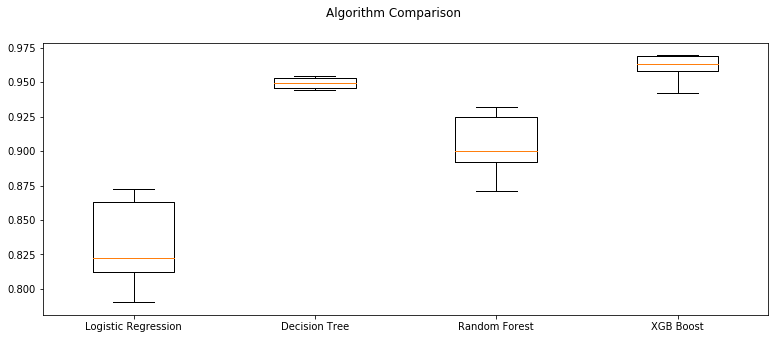

In [461]:
names = ["Logistic Regression", "Decision Tree", "Random Forest", "XGB Boost"]
fig = plt.figure(figsize = (13,5))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(rb,showfliers=False)
ax.set_xticklabels(names)
plt.savefig('2 BOX.png')
plt.show()

### Logistic Regression with Gredisearch

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(max_iter = 4000)
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X1,y)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1000.0, 'penalty': 'l2'}
accuracy : 0.8191100484435582


In [107]:
logreg_C = LogisticRegression(**logreg_cv.best_params_,max_iter = 3000)
logreg_C.fit(X_train,y_train)
y_train_pred = logreg_C.predict(X_train)
y_train_prob = logreg_C.predict_proba(X_train)[:,1]
y_test_pred = logreg_C.predict(X_test)
y_test_prob = logreg_C.predict_proba(X_test)[:,1]
#Scores
print("Accuracy",accuracy_score(y_train,y_train_pred))
print("AUC train", roc_auc_score(y_train,y_train_prob))
print("F1 train", f1_score(y_train,y_train_pred))
print("recall",recall_score(y_train,y_train_pred))
print("Precision",precision_score(y_train,y_train_pred))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred))
print("AUC test",roc_auc_score(y_test,y_test_prob))
print("F1 test",f1_score(y_test,y_test_pred))
print("recall",recall_score(y_test,y_test_pred))
print("Precision",precision_score(y_test,y_test_pred))

Accuracy 0.830018018018018
AUC train 0.9188395387413342
F1 train 0.81648056647084
recall 0.8107084910762574
Precision 0.8223354231974922


Accuracy 0.8276441903480747
AUC test 0.9178809133199206
F1 test 0.8134328358208955
recall 0.8056607175049576
Precision 0.8213563683146481


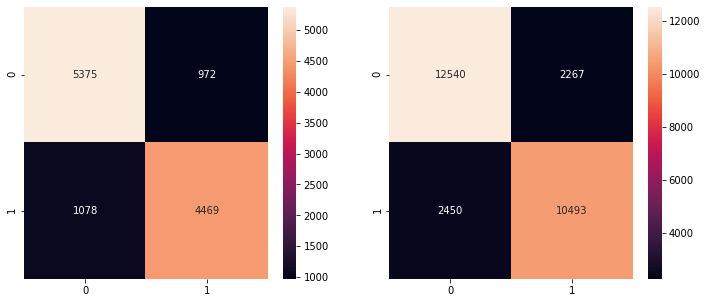

In [108]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_pred),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_pred),fmt = 'd',annot = True,ax = axes[1])
#plt.savefig("Logistic median.png")
plt.show()

### Decision Tree

In [77]:
from sklearn.tree import DecisionTreeClassifier as dct

dt = dct()
dt.fit(X_train,y_train)
y_train_pred = dt.predict(X_train)
y_train_prob = dt.predict_proba(X_train)[::,1]
y_test_pred = dt.predict(X_test)
y_test_prob = dt.predict_proba(X_test)[::,1]
print("Accuracy",accuracy_score(y_train,y_train_pred))
print("AUC train", roc_auc_score(y_train,y_train_prob))
print("F1 train", f1_score(y_train,y_train_pred))
print("recall",recall_score(y_train,y_train_pred))
print("Precision",precision_score(y_train,y_train_pred))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred))
print("AUC test",roc_auc_score(y_test,y_test_prob))
print("F1 test",f1_score(y_test,y_test_pred))
print("recall",recall_score(y_test,y_test_pred))
print("Precision",precision_score(y_test,y_test_pred))

Accuracy 1.0
AUC train 1.0
F1 train 1.0
recall 1.0
Precision 1.0


Accuracy 0.9421557087607197
AUC test 0.9420632525941217
F1 test 0.9381517439769868
recall 0.9406886605372273
Precision 0.9356284740900126


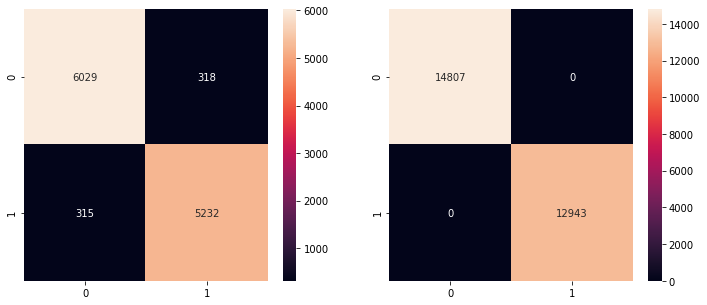

In [110]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_pred),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_pred),fmt = 'd',annot = True,ax = axes[1])
#plt.savefig("Logistic median.png")
plt.show()

### Decision Tree with Grid search

In [343]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

dt = dct(random_state = 3)
params = {"max_depth": [2,3,4,5,6,8,10,12,14,16], 'min_samples_split':[2,4,6,8,10,12,14,16],'min_samples_leaf':[1,2,4,6,8,10]}
skf = StratifiedKFold(n_splits=5, shuffle = True)
gsearch = GridSearchCV(dt,param_grid=params, cv = skf, scoring = 'roc_auc',return_train_score=True,n_jobs = -1)

gsearch.fit(X2,y)
gsearch.best_params_

{'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 2}

In [244]:
gsearch.best_params_

{'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 2}

In [344]:
dt = dct(**gsearch.best_params_)
dt.fit(X_train,y_train)
y_train_pred_dt = dt.predict(X_train)
y_train_prob_dt = dt.predict_proba(X_train)[::,1]
y_test_pred_dt = dt.predict(X_test)
y_test_prob_dt = dt.predict_proba(X_test)[::,1]
print("Accuracy",accuracy_score(y_train,y_train_pred_dt))
print("AUC train", roc_auc_score(y_train,y_train_prob_dt))
print("F1 train", f1_score(y_train,y_train_pred_dt))
print("recall",recall_score(y_train,y_train_pred_dt))
print("Precision",precision_score(y_train,y_train_pred_dt))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred_dt))
print("AUC test",roc_auc_score(y_test,y_test_prob_dt))
print("F1 test",f1_score(y_test,y_test_pred_dt))
print("recall",recall_score(y_test,y_test_pred_dt))
print("Precision",precision_score(y_test,y_test_pred_dt))

Accuracy 0.9634954954954955
AUC train 0.9950009027274056
F1 train 0.9616882871298362
recall 0.9823070385536583
Precision 0.9419173210846051


Accuracy 0.949470321170338
AUC test 0.9824469039497445
F1 test 0.9469970896904488
recall 0.967910582296737
Precision 0.9269682320441989


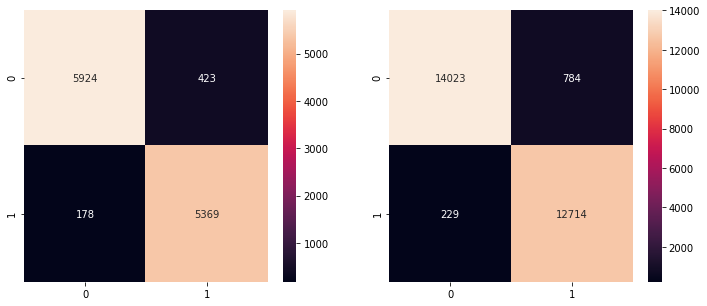

In [345]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_pred_dt),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_pred_dt),fmt = 'd',annot = True,ax = axes[1])
plt.savefig("DT CM.png")
plt.show()

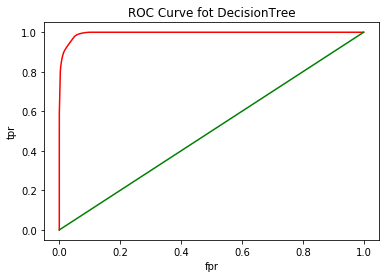

In [356]:
fpr, tpr, thresholds =roc_curve(y_train,y_train_prob_dt)
plt.plot(fpr,tpr,"r")
plt.plot(fpr,fpr,"g")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve fot DecisionTree")
plt.savefig('ROC Curve fot DecisionTree.png')
plt.show()

In [453]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
scoring = {'accuracy' : make_scorer(accuracy_score)}

model_dt = dct(**gsearch.best_params_)
results_dt = cross_validate(model_dt, X_train, y_train, cv=10, scoring = scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(results_dt['test_accuracy']), np.std(results_dt['test_accuracy']) * 2))

Accuracy: 0.95 (+/- 0.01)


In [454]:
results_dt

{'fit_time': array([0.855232  , 0.78708005, 0.79365206, 0.79297376, 0.84193993,
        0.91700697, 1.09190392, 0.93042302, 0.89260507, 0.77008104]),
 'score_time': array([0.00589013, 0.00721979, 0.00377893, 0.00379896, 0.00662303,
        0.00377989, 0.00455594, 0.0037148 , 0.00379515, 0.00380778]),
 'test_accuracy': array([0.94882883, 0.95387387, 0.95387387, 0.95099099, 0.94486486,
        0.94630631, 0.94954955, 0.95459459, 0.94558559, 0.9445045 ])}

### RandomForest

In [114]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=3)

rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_train_prob = rf.predict_proba(X_train)[:,1]

print('f1_score', f1_score(y_train, y_train_pred))
print('recall_score:', recall_score(y_train, y_train_pred))
print('precision_score:', precision_score(y_train, y_train_pred))
print('Accuracy on Train: ', accuracy_score(y_train, y_train_pred))
print('AUC on Train: ',  roc_auc_score(y_train, y_train_prob))

y_test_pred = rf.predict(X_test)
y_test_prob = rf.predict_proba(X_test)[:,1] 

print('\n')
print('f1_score:', f1_score(y_test, y_test_pred))
print('recall_score:', recall_score(y_test, y_test_pred))
print('precision_score:', precision_score(y_test, y_test_pred))
print('Accuracy on Test: ', accuracy_score(y_test, y_test_pred))
print('AUC on Test: ', roc_auc_score(y_test, y_test_prob))

f1_score 1.0
recall_score: 1.0
precision_score: 1.0
Accuracy on Train:  1.0
AUC on Train:  1.0


f1_score: 0.9650362318840578
recall_score: 0.9603389219397873
precision_score: 0.9697797196431822
Accuracy on Test:  0.9675466621826131
AUC on Test:  0.9962905044873565


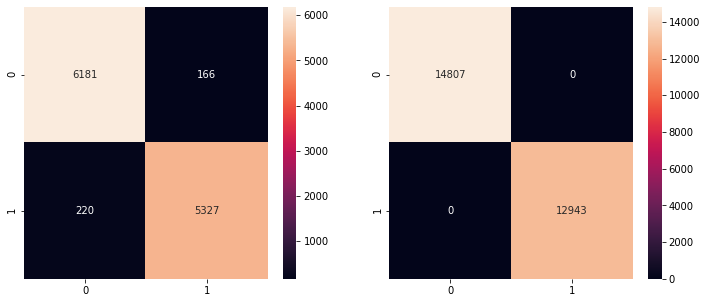

In [115]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_pred),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_pred),fmt = 'd',annot = True,ax = axes[1])
#plt.savefig("Logistic median.png")
plt.show()

### RandomForest with gridsearch

In [346]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

rf = RandomForestClassifier(random_state=3)
skf = StratifiedKFold(n_splits=6, shuffle = True)
params = {
    'n_estimators': sp_randint(50, 200),
    'max_features': sp_randint(1, 14),
    'max_depth': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 20),
    'min_samples_split': sp_randint(2, 20)}

rsearch = RandomizedSearchCV(rf, param_distributions=params, scoring='roc_auc', n_iter=100,
                            cv=skf, random_state=3, n_jobs=-1, return_train_score=True)

rsearch.fit(X2, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=True),
                   estimator=RandomForestClassifier(random_state=3), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x130979e90>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x131815fd0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x130979090>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x130979c50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x145a02350>},
                   random_state=3, return_train_score=True, scoring='roc_auc')

In [35]:
rsearch.best_params_

{'max_depth': 9,
 'max_features': 8,
 'min_samples_leaf': 12,
 'min_samples_split': 12,
 'n_estimators': 162}

In [347]:
rsearch.best_params_

{'max_depth': 9,
 'max_features': 11,
 'min_samples_leaf': 10,
 'min_samples_split': 7,
 'n_estimators': 109}

In [348]:
rf = RandomForestClassifier(**rsearch.best_params_, oob_score=True,  random_state=3)

rf.fit(X_train, y_train)
y_train_pred_rf = rf.predict(X_train)
y_train_prob_rf = rf.predict_proba(X_train)[:,1]

print('f1_score:', f1_score(y_train, y_train_pred_rf))
print('recall_score:', recall_score(y_train, y_train_pred_rf))
print('precision_score:', precision_score(y_train, y_train_pred_rf))
print('Accuracy on Train: ', accuracy_score(y_train, y_train_pred_rf))
print('AUC on Train: ',  roc_auc_score(y_train, y_train_prob_rf))

y_test_pred_rf = rf.predict(X_test)
y_test_prob_rf = rf.predict_proba(X_test)[:,1] 

print('\n')
print('f1_score:', f1_score(y_test, y_test_pred_rf))
print('recall_score:', recall_score(y_test, y_test_pred_rf))
print('precision_score:', precision_score(y_test, y_test_pred_rf))
print('Accuracy on Test: ', accuracy_score(y_test, y_test_pred_rf))
print('AUC on Test: ', roc_auc_score(y_test, y_test_prob_rf))

f1_score: 0.9231795936526769
recall_score: 0.9619099126941204
precision_score: 0.8874474303229025
Accuracy on Train:  0.9253333333333333
AUC on Train:  0.9878464703968939


f1_score: 0.9223284100781929
recall_score: 0.9569136470164052
precision_score: 0.8901559617642126
Accuracy on Test:  0.9248360517908188
AUC on Test:  0.985422720360712


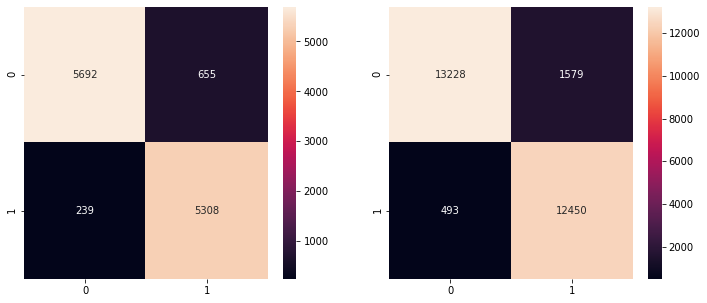

In [359]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_pred_rf),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_pred_rf),fmt = 'd',annot = True,ax = axes[1])
plt.savefig("RF CM.png")
plt.show()

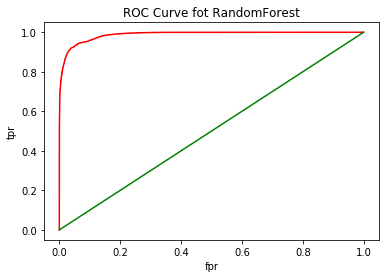

In [360]:
fpr, tpr, thresholds =roc_curve(y_train,y_train_prob_rf)
plt.plot(fpr,tpr,"r")
plt.plot(fpr,fpr,"g")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve fot RandomForest")
plt.savefig('ROC Curve fot RF.png')
plt.show()

In [420]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'AUC' : make_scorer(roc_auc_score)}

model_rf = RandomForestClassifier(**rsearch.best_params_, oob_score=True,  random_state=3)
results_rf = cross_validate(model_rf, X2, y, cv=10, scoring = scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(results_rf['test_accuracy']), np.std(results_rf['test_accuracy']) * 2))

Accuracy: 0.92 (+/- 0.08)


In [ ]:
for name, importance in zip(X2.columns, rf.feature_importances_):
    print(name, "=", importance)

In [355]:
pd.DataFrame(zip(X2.columns, rf.feature_importances_)).to_csv(r"/Users/anupbanerjee/Downloads/Project 3/OnlineNewsPopularity/FI.csv")


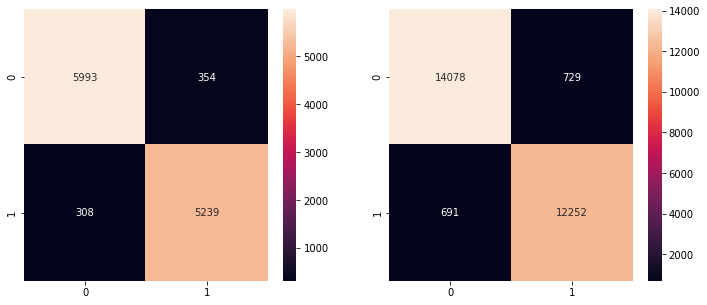

In [119]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_pred),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_pred),fmt = 'd',annot = True,ax = axes[1])
#plt.savefig("Logistic mean.png")
plt.show()

In [ ]:
### KNN

In [120]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_train_pred = knn.predict(X_train)
y_train_prob = knn.predict_proba(X_train)[:,1]
y_test_pred = knn.predict(X_test)
y_test_prob = knn.predict_proba(X_test)[:,1] 

print("Accuracy",accuracy_score(y_train,y_train_pred))
print("AUC train", roc_auc_score(y_train,y_train_prob))
print("F1 train", f1_score(y_train,y_train_pred))
print("recall",recall_score(y_train,y_train_pred))
print("Precision",precision_score(y_train,y_train_pred))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred))
print("AUC test",roc_auc_score(y_test,y_test_prob))
print("F1 test",f1_score(y_test,y_test_pred))
print("recall",recall_score(y_test,y_test_pred))
print("Precision",precision_score(y_test,y_test_pred))

Accuracy 0.8888648648648648
AUC train 0.9592670250029115
F1 train 0.8857185207144447
recall 0.9233562543459786
Precision 0.8510289824111658


Accuracy 0.8188162098537077
AUC test 0.8994539522170271
F1 test 0.8158591814064771
recall 0.8606453939066162
Precision 0.7755035737491878


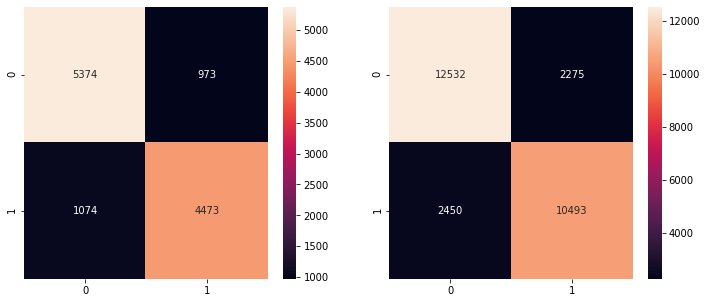

In [138]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_pred),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_pred),fmt = 'd',annot = True,ax = axes[1])
plt.savefig("Logistic mean.png")
plt.show()

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_pred),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_pred),fmt = 'd',annot = True,ax = axes[1])
#plt.savefig("Logistic mean.png")
plt.show()

In [361]:
from xgboost import XGBClassifier

XGB = XGBClassifier()
XGB.fit(X_train, y_train)


y_train_predx = XGB.predict(X_train)
y_train_probx = XGB.predict_proba(X_train)[:,1]

y_test_predx = XGB.predict(X_test)
y_test_probx = XGB.predict_proba(X_test)[:,1]


print("Accuracy",accuracy_score(y_train,y_train_predx))
print("AUC train", roc_auc_score(y_train,y_train_probx))
print("F1 train", f1_score(y_train,y_train_predx))
print("recall",recall_score(y_train,y_train_predx))
print("Precision",precision_score(y_train,y_train_predx))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_predx))
print("AUC test",roc_auc_score(y_test,y_test_probx))
print("F1 test",f1_score(y_test,y_test_predx))
print("recall",recall_score(y_test,y_test_predx))
print("Precision",precision_score(y_test,y_test_predx))

Accuracy 0.9990990990990991
AUC train 0.9999935193350612
F1 train 0.9990347117649331
recall 0.9995364289577378
Precision 0.9985334979932078


Accuracy 0.9759542626534387
AUC test 0.998209153235103
F1 test 0.9742852005035065
recall 0.9767441860465116
Precision 0.9718385650224215


In [393]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import time

params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
    }



xgb = XGBClassifier(learning_rate=0.02, n_estimators=600,
                silent=True, nthread=1)

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, 
                                   scoring=['f1_macro','precision_macro'],
                                   n_jobs=-1, cv=skf.split(X2,y), verbose=3, refit = 'f1_macro')


random_search.fit(X2, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 10.6min finished


[12:22:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x143005ed0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=na...
                                           reg_lambda=None,
                                           scale_pos_weight=None, silent=True,
                                           subsample=None, tree_method=None,
                                           valida

In [417]:
random_search.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 5,
 'gamma': 2,
 'colsample_bytree': 0.6}

In [396]:
xgb = XGBClassifier(**random_search.best_params_,learning_rate=0.02, n_estimators=600,
                silent=True, nthread=1)
xgb.fit(X_train,y_train)
y_train_predX = xgb.predict(X_train)
y_train_probX = xgb.predict_proba(X_train)[:,1]

y_test_predX = xgb.predict(X_test)
y_test_probX = xgb.predict_proba(X_test)[:,1]

print("Accuracy",accuracy_score(y_train,y_train_predX))
print("AUC train", roc_auc_score(y_train,y_train_probX))
print("F1 train", f1_score(y_train,y_train_predX))
print("recall",recall_score(y_train,y_train_predX))
print("Precision",precision_score(y_train,y_train_predX))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_predX))
print("AUC test",roc_auc_score(y_test,y_test_probX))
print("F1 test",f1_score(y_test,y_test_predX))
print("recall",recall_score(y_test,y_test_predX))
print("Precision",precision_score(y_test,y_test_predX))

[12:36:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy 0.9795315315315315
AUC train 0.9987981810370202
F1 train 0.9783023913209566
recall 0.9893378660279688
Precision 0.9675103891197582


Accuracy 0.9744408945686901
AUC test 0.997905518787573
F1 test 0.972876516773733
recall 0.98287362538309
Precision 0.9630807277866101


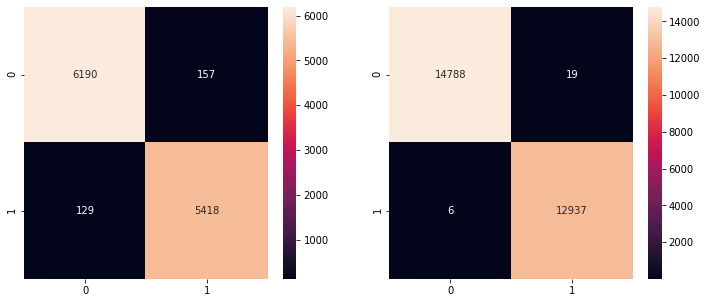

In [397]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_predx),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_predx),fmt = 'd',annot = True,ax = axes[1])
plt.savefig("XGB CM.png")
plt.show()

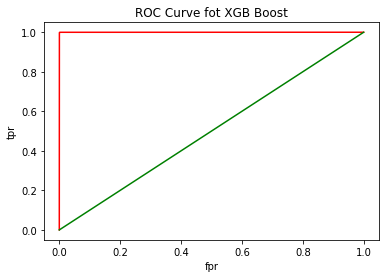

In [398]:
fpr, tpr, thresholds =roc_curve(y_train,y_train_probx)
plt.plot(fpr,tpr,"r")
plt.plot(fpr,fpr,"g")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve fot XGB Boost")
plt.savefig('ROC Curve fot XGB.png')
plt.show()

In [201]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'AUC' : make_scorer(roc_auc_score)}

model = XGBClassifier()
kfold = StratifiedKFold(n_splits=10)
results = cross_validate(model, X1, y, cv=kfold, scoring = scoring)

from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(model, X_train,y_train ,cv=kfold)
y_test_pred=cross_val_predict(model, X_test,y_test ,cv=kfold)
y_train_proba=cross_val_predict(model, X_train,y_train ,cv=kfold, method = 'predict_proba')
y_test_proba=cross_val_predict(model, X_test,y_test ,cv=kfold,method = 'predict_proba')


In [403]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'AUC' : make_scorer(roc_auc_score)}

model = XGBClassifier(**random_search.best_params_,learning_rate=0.02, n_estimators=600,silent=True, nthread=1)
results = cross_validate(model, X2, y, cv=10, scoring = scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(results['test_accuracy']), np.std(results['test_accuracy']) * 2))

[15:13:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:14:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:15:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

In [439]:
results

{'fit_time': array([69.25101209, 66.2053051 , 69.17872572, 63.73793197, 62.39188814,
        63.07755423, 65.52575803, 66.41166282, 62.42427611, 61.79299593]),
 'score_time': array([0.12114286, 0.14272213, 0.23449612, 0.12527204, 0.12439489,
        0.12595487, 0.14360213, 0.12520695, 0.12501788, 0.12081981]),
 'test_accuracy': array([1.        , 1.        , 0.94249685, 0.95636822, 0.96442987,
        0.96241171, 0.96720484, 0.96947528, 0.96266398, 0.94576186]),
 'test_precision': array([1.        , 1.        , 0.93834505, 0.92195368, 0.94994731,
        0.94736842, 0.95213046, 0.95859873, 0.94598846, 0.89892578]),
 'test_recall': array([1.        , 1.        , 0.93834505, 0.99026501, 0.97512169,
        0.97349919, 0.97890752, 0.97674419, 0.97566252, 0.99567334]),
 'test_f1_score': array([1.        , 1.        , 0.93834505, 0.95488918, 0.9623699 ,
        0.96025607, 0.96533333, 0.96758639, 0.96059638, 0.94482936]),
 'test_AUC': array([1.        , 1.        , 0.94223491, 0.9585068 , 0

In [440]:
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(results['test_accuracy']), np.std(results['test_accuracy']) * 2))

Accuracy: 0.97 (+/- 0.04)


In [173]:
from sklearn.model_selection import cross_validate

In [202]:
print("Accuracy",accuracy_score(y_train,y_train_pred))
print("AUC train", roc_auc_score(y_train,y_train_prob))
print("F1 train", f1_score(y_train,y_train_pred))
print("recall",recall_score(y_train,y_train_pred))
print("Precision",precision_score(y_train,y_train_pred))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred))
print("AUC test",roc_auc_score(y_test,y_test_prob))
print("F1 test",f1_score(y_test,y_test_pred))
print("recall",recall_score(y_test,y_test_pred))
print("Precision",precision_score(y_test,y_test_pred))

Accuracy 0.9754234234234235
AUC train 0.9999961804776689
F1 train 0.9737571186701555
recall 0.977594066290659
Precision 0.9699501724798774


Accuracy 0.9733479065074828
AUC test 0.9982050063100011
F1 test 0.9715414310081695
recall 0.9754822426536867
Precision 0.9676323319027181


In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds =roc_curve(y_train,y_train_prob)
plt.plot(fpr,tpr,"r")
plt.plot(fpr,fpr,"g")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("RandomForest with RandomizedSearchCV")
plt.savefig('RandomForest with RandomizedSearchCV.png')
plt.show()

In [371]:
X_best = dfd[['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs',
       'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity']]

In [372]:
X_best.shape

(39644, 56)

In [412]:
import lightgbm as lgb
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

lgbc = lgb.LGBMClassifier(random_state = 3)

params = {'n_estimators' :sp_randint(70,200),
          'max_depth': sp_randint(1,10),
          'learning_rate': sp_uniform(0,0.5)}
skf = StratifiedKFold(n_splits=5)
rsearch_lgbm = RandomizedSearchCV(lgbc, param_distributions = params, cv = 10, n_iter=10, n_jobs = 2, scoring = ['f1_macro','precision_macro'], refit ='f1_macro')

rsearch_lgbm.fit(X2,y)
rsearch_lgbm.best_params_

{'learning_rate': 0.18465994996693907, 'max_depth': 3, 'n_estimators': 119}

In [407]:
rsearch_lgbm.best_params_

{'learning_rate': 0.3293374294921441, 'max_depth': 8, 'n_estimators': 141}

In [410]:
gbc_r = lgb.LGBMClassifier(**rsearch_lgbm.best_params_)
gbc_r.fit(X_train,y_train)
y_train_predL = gbc_r.predict(X_train)
y_train_probL = gbc_r.predict_proba(X_train)[:,1]

y_test_predL = gbc_r.predict(X_test)
y_test_probL = gbc_r.predict_proba(X_test)[:,1]

In [413]:
print("Accuracy",accuracy_score(y_train,y_train_predL))
print("AUC train", roc_auc_score(y_train,y_train_probL))
print("F1 train", f1_score(y_train,y_train_predL))
print("recall",recall_score(y_train,y_train_predL))
print("Precision",precision_score(y_train,y_train_predL))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_predL))
print("AUC test",roc_auc_score(y_test,y_test_probL))
print("F1 test",f1_score(y_test,y_test_predL))
print("recall",recall_score(y_test,y_test_predL))
print("Precision",precision_score(y_test,y_test_predL))

Accuracy 1.0
AUC train 1.0
F1 train 1.0
recall 1.0
Precision 1.0


Accuracy 0.9742727425592735
AUC test 0.9980807973821202
F1 test 0.9725363489499192
recall 0.9767441860465116
Precision 0.9683646112600536


In [438]:
results

{'fit_time': array([69.25101209, 66.2053051 , 69.17872572, 63.73793197, 62.39188814,
        63.07755423, 65.52575803, 66.41166282, 62.42427611, 61.79299593]),
 'score_time': array([0.12114286, 0.14272213, 0.23449612, 0.12527204, 0.12439489,
        0.12595487, 0.14360213, 0.12520695, 0.12501788, 0.12081981]),
 'test_accuracy': array([1.        , 1.        , 0.94249685, 0.95636822, 0.96442987,
        0.96241171, 0.96720484, 0.96947528, 0.96266398, 0.94576186]),
 'test_precision': array([1.        , 1.        , 0.93834505, 0.92195368, 0.94994731,
        0.94736842, 0.95213046, 0.95859873, 0.94598846, 0.89892578]),
 'test_recall': array([1.        , 1.        , 0.93834505, 0.99026501, 0.97512169,
        0.97349919, 0.97890752, 0.97674419, 0.97566252, 0.99567334]),
 'test_f1_score': array([1.        , 1.        , 0.93834505, 0.95488918, 0.9623699 ,
        0.96025607, 0.96533333, 0.96758639, 0.96059638, 0.94482936]),
 'test_AUC': array([1.        , 1.        , 0.94223491, 0.9585068 , 0